In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
Root = "/content/drive/MyDrive/dataset"
os.chdir(Root)

In [7]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [8]:
data = '/content/drive/MyDrive/dataset'
No_breast_cancer = '/content/drive/MyDrive/dataset/Yes'
Yes_breast_cancer = '/content/drive/MyDrive/dataset/No'

In [9]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5476    labels:  5476


In [10]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5476,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/dataset/Yes/9126_idx5_x...,No
1,/content/drive/MyDrive/dataset/Yes/9126_idx5_x...,No
2,/content/drive/MyDrive/dataset/Yes/9126_idx5_x...,No
3,/content/drive/MyDrive/dataset/Yes/9126_idx5_x...,No
4,/content/drive/MyDrive/dataset/Yes/9126_idx5_x...,No


In [11]:
print(df['labels'].value_counts())

labels
No     3123
Yes    2353
Name: count, dtype: int64


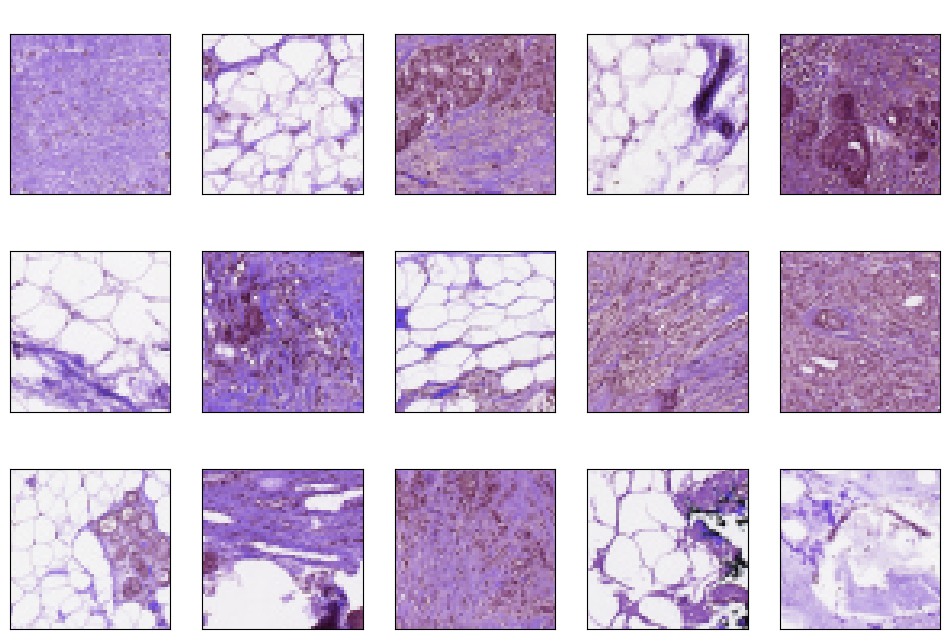

In [12]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (4681, 2)
test set shape: (274, 2)
validation set shape: (521, 2)


In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [15]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 4681 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.
Found 274 validated image filenames belonging to 2 classes.


In [16]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [17]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)


base_model.trainable = False


inputs = keras.Input(shape=(224, 224, 3))


x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00

In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.6114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 808s 5s/step - loss: 0.6553 - accuracy: 0.6114 - val_loss: 0.5529 - val_accuracy: 0.7409
Epoch 2/10
147/147 [==============================] - 92s 622ms/step - loss: 0.5495 - accuracy: 0.7242 - val_loss: 0.4923 - val_accuracy: 0.7774
Epoch 3/10
147/147 [==============================] - 91s 619ms/step - loss: 0.4868 - accuracy: 0.7768 - val_loss: 0.4722 - val_accuracy: 0.7774
Epoch 4/10
147/147 [==============================] - 119s 808ms/step - loss: 0.4786 - accuracy: 0.7832 - val_loss: 0.4441 - val_accuracy: 0.8292
Epoch 5/10
147/147 [==============================] - 117s 795ms/step - loss: 0.4528 - accuracy: 0.7985 - val_loss: 0.4317 - val_accuracy: 0.8119
Epoch 6/10
147/147 [==============================] - 116s 789ms/step - loss: 0.4498 - accuracy: 0.8062 - val_loss: 0.4359 - val_accuracy: 0.8119
Epoch 7/10
147/147 [==============================] - 115s 782ms/step - loss: 0.4378 - accuracy: 0.8079 - val_loss: 0.4401 - val_accuracy: 0

In [19]:
model.save("model.h5")

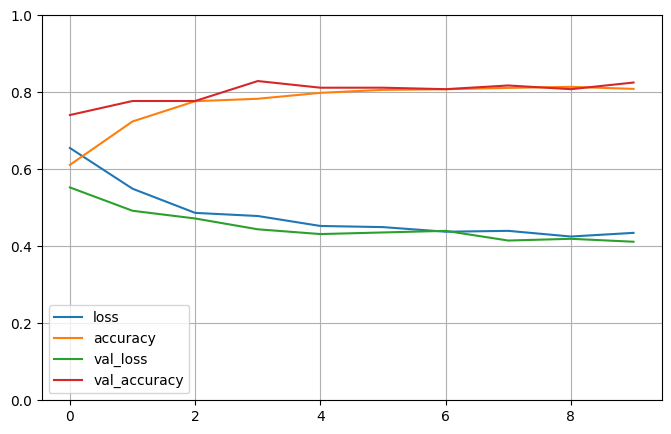

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [2]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/dataset/No/8959_idx5_x501_y301_class1.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred <= 0.5:
  print("yes")
else:
  print("no")

NameError: name 'tf' is not defined

In [ ]:
train_gen.class_indices